## Imagery layers and Raster analysis


In [1]:
import arcgis

### Access imagery

In [2]:
from arcgis.gis import GIS

In [3]:
gis = GIS(profile='your_online_profile', verify_cert=False)

In [4]:
landsat_item = gis.content.search('title: Multispectral Landsat',
                                  'Imagery Layer', outside_org=True)[0]

In [5]:
landsat_item.layers

[<ImageryLayer url:"https://landsat2.arcgis.com/arcgis/rest/services/Landsat/MS/ImageServer">]

### View Landsat imagery layer item description

In [6]:
from IPython.display import HTML
HTML(landsat_item.description)

Band,Description,Wavelength (µm),Spatial Resolution (m)
1,Coastal aerosol,0.43 - 0.45,30
2,Blue,0.45 - 0.51,30
3,Green,0.53 - 0.59,30
4,Red,0.64 - 0.67,30
5,Near Infrared (NIR),0.85 - 0.88,30
6,SWIR 1,1.57 - 1.65,30
7,SWIR 2,2.11 - 2.29,30
8,Cirrus (in OLI this is band 9),1.36 - 1.38,30
9,QA Band (available with Collection 1)*,NA,30
Band,Description,Wavelength (µm),Spatial Resolution (m)


### Access the layers available with the Landsat Imagery Layer item

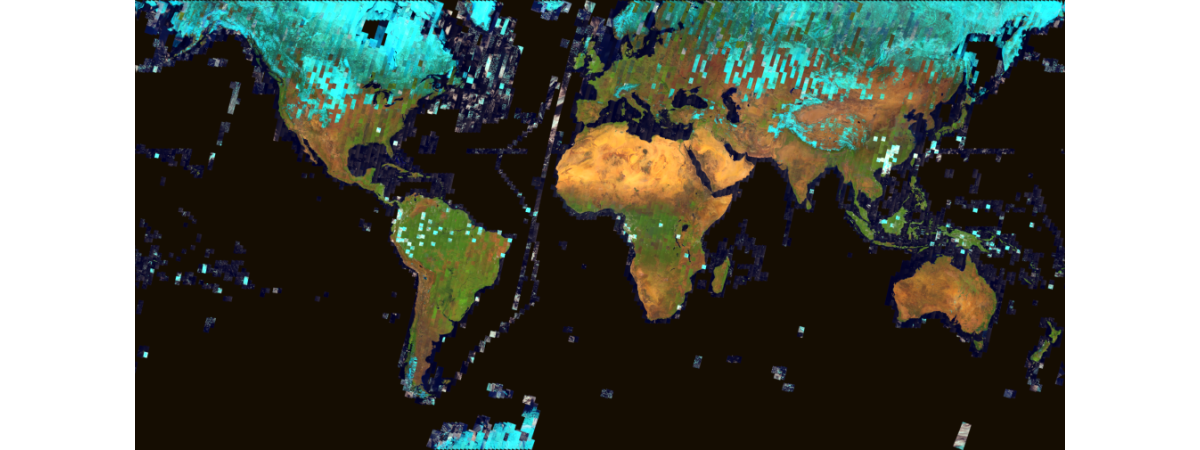

In [7]:
landsat = landsat_item.layers[0]
landsat 

## Explore different wavelength bands

In [8]:
import pandas as pd

In [9]:
pd.DataFrame(landsat.key_properties()['BandProperties'])

,BandName,WavelengthMax,WavelengthMin
0,CoastalAerosol,450,430
1,Blue,510,450
2,Green,590,530
3,Red,670,640
4,NearInfrared,880,850
5,ShortWaveInfrared_1,1650,1570
6,ShortWaveInfrared_2,2290,2110
7,Cirrus,1380,1360
8,QA,0,0
9,ThermalInfrared1,11190,10600


## Visualize the layer in the map widget

In [13]:
m = gis.map('Paris, France')
m

MapView(layout=Layout(height='400px', width='100%'))

In [11]:
m.add_layer(landsat)

In [15]:
import time
from arcgis.raster.functions import apply

for idx, rasterfunc in enumerate(landsat.properties.rasterFunctionInfos):
    m.add_layer(apply(landsat, rasterfunc.name))
    print(rasterfunc.name)
    time.sleep(2)
    if idx > 4:
        break

Agriculture with DRA
Bathymetric with DRA
Color Infrared with DRA
Natural Color with DRA
Short-wave Infrared with DRA
Geology with DRA


### Interactive raster processing in Jupyter Notebook

In [16]:
color_infrared = apply(landsat, 'Color Infrared with DRA')

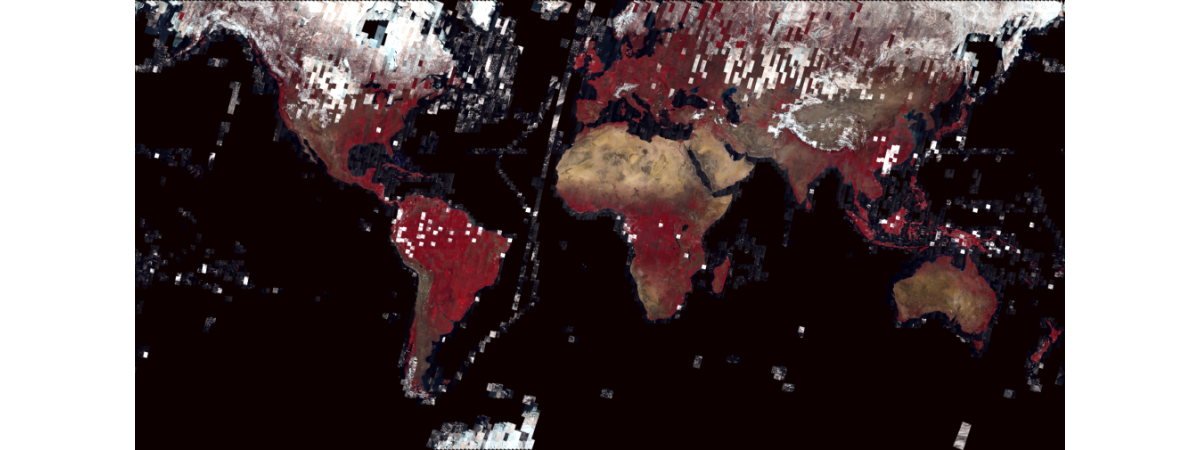

In [17]:
color_infrared 

In [ ]:
m = gis.map('Laval, France')
m

In [ ]:
m.add_layer(color_infrared)

### Setting an area of interest

In [19]:
from arcgis.geocoding import geocode
area = geocode('Paris, France', out_sr=landsat.properties.spatialReference)[0]

In [20]:
color_infrared.extent = area['extent']

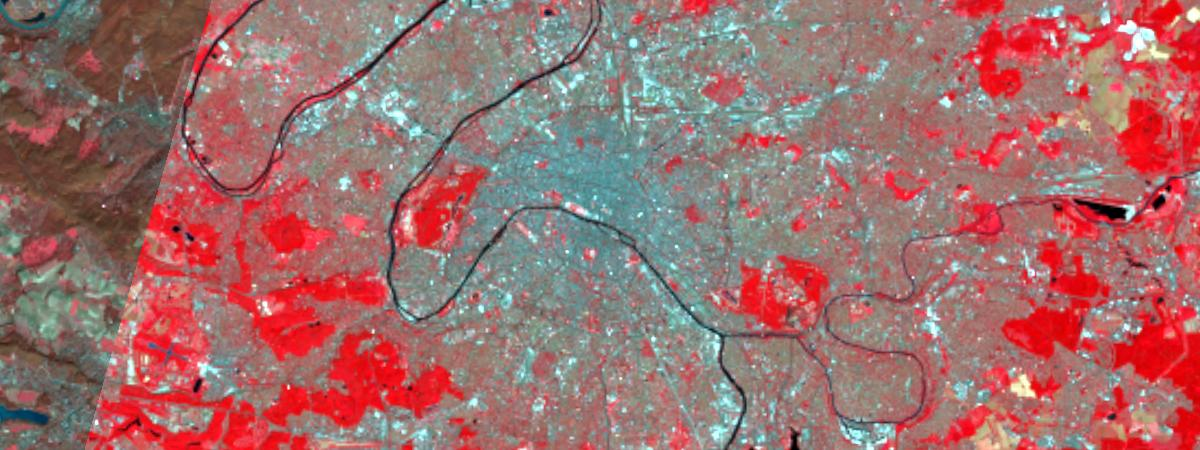

In [21]:
color_infrared

In [ ]:
landsat.extent = area['extent']
landsat

## Exporting Images from Imagery Layer

In [ ]:
from IPython.display import Image

### Exports an image to binary

In [ ]:
img = landsat.export_image(bbox=area['extent'], size=[1200,450], f='image')

In [ ]:
Image(img)

In [ ]:
savedimg = landsat.export_image(bbox=area['extent'], size=[1200,450], 
                                f='image', save_folder='.', 
                                save_file='img.jpg')

In [ ]:
savedimg

In [ ]:
from IPython.display import Image

In [ ]:
Image(filename=savedimg, width=1200, height=450)

### Exporting images with raster function applied to them

In [ ]:
ndvi_colorized = apply(landsat, 'NDVI Colorized')
ndvi_colorized.extent = area['extent']
ndvi_colorized

## Extracting custom bands

In [ ]:
from arcgis.raster.functions import stretch, extract_band

In [ ]:
naturalcolor = stretch(extract_band(landsat, [3,2,1]), 
                    stretch_type='percentclip', min_percent=0.1, max_percent=0.1, 
                       gamma=[1, 1, 1], dra=True)
naturalcolor.extent = area['extent']
naturalcolor

# Clipping to an area of interest

In [ ]:
from arcgis.geometry import Geometry, buffer 
from arcgis.raster.functions import clip, apply
%config IPCompleter.greedy=True

In [ ]:
poly = buffer(geometries=[Geometry(area['location'])],
              in_sr=102100, distances=6000, unit=9001)[0]

In [ ]:
from  arcgis.geoenrichment import Country
usa = Country.get('US')
redlands = usa.subgeographies.states['California'].zip5['92373']

In [ ]:
redclip = clip(apply(landsat, 'NDVI Colorized'), redlands.geometry)

In [ ]:
m = gis.map('Redlands, CA')

In [ ]:
m 

In [ ]:
m.add_layer(redclip)

## Select images by where clause, geometry and time range

In [ ]:
import arcgis

In [ ]:
sentinel_item = gis.content.search('Sentinel-2 Views', outside_org=True)[0]
sentinel_item

In [ ]:
sentinel = sentinel_item.layers[0]
sentinel.extent = area['extent']

In [ ]:
selected = sentinel.filter_by(where="cloudcover <= .01 and category = 1",
                              geometry=arcgis.geometry.filters.intersects(area['extent']))

df = selected.query(out_fields="AcquisitionDate, Tile_ID, CloudCover", order_by_fields="AcquisitionDate").sdf
df['acquisitiondate'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df.tail()

Looking at the shape of the dataframe we see that multiple scenes match the specified criteria:

In [ ]:
df.shape

The footprints of the rasters matching the criteria can be drawn using the map widget:

In [ ]:
df['Time'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df['Time'].tail(10)

# Change Detection

In [ ]:
new = selected.last()
new

In [ ]:
old = selected.first()
old

## Difference Image

Difference Image mode illustrates all the changes in NDVI (vegeration index) between the two dates:

increases are shown in green, and decreases are shown in magenta. 

In [ ]:
from arcgis.raster.functions import *

In [ ]:
diff = stretch(composite_band([ndvi(old, '3 4'),
                               ndvi(new, '3 4')]), 
                               stretch_type='stddev',  num_stddev=3, min=0, 
                               max=255, dra=True, astype='u8')
diff

### Persisting your analysis for visualizaion or analysis

```python
lyr = diff.save('Test_viz_layer3')
```